In [1]:
try:
    import seqeval
except ModuleNotFoundError as err:
    !pip install seqeval

     |████████████████████████████████| 43 kB 570 kB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16181 sha256=ade1363bc8447fedbe1dbb8e7b3642706c124f7a67af44a4e25e8af29901c318
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [2]:
import os
import shutil
 
dir = './'
for f in os.listdir(dir):
    if not os.path.isdir(f):
        os.remove(os.path.join(dir, f))
    else:
        shutil.rmtree(f)
    
print(os.listdir(dir))

[]


In [3]:
import sys
sys.path.append('../input/libsutils')

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import requests
import tarfile
from itertools import islice

from tabulate import tabulate
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report as eskclarep
from seqeval.metrics import precision_score, recall_score, f1_score, accuracy_score
from seqeval.metrics import classification_report as seqclarep
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import KFold
from itertools import chain

from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, Dropout, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from sklearn import preprocessing
from tokenizers import BertWordPieceTokenizer
from utils import build_matrix_embeddings as bme, plot_model_performance, logits_to_tokens, report_to_df
from transformers import (
    TF2_WEIGHTS_NAME,
    BertConfig,
    BertTokenizer,
    TFBertForTokenClassification,
    create_optimizer)

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard
import tensorflow.keras.backend as kb

from IPython.core.display import display, HTML
from crfta import CRF as crf4

import datetime, os
import random
import time
from tqdm import tqdm

SEED = 42
os.environ['PYTHONHASHSEED']=str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # TF 2.1+
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

MODEL         = 'model-08-bert-new-lung'
logs_base_dir = "./logs"
log_dir       = logs_base_dir + "/" + MODEL
save_base_dir = './model-save'
save_dir      = save_base_dir + "/" + MODEL

os.makedirs(logs_base_dir, exist_ok=True)
os.makedirs(log_dir,       exist_ok=True)
os.makedirs(save_base_dir, exist_ok=True)
os.makedirs(save_dir,      exist_ok=True)

%load_ext tensorboard

# ****** DEFINICION DE PARAMETROS *********
LEN_SENTS   = 306
MAX_LEN     = 596
NUM_TAGS    = 37 + 3

# ****** DEFINICION DE HIPERPARAMETROS *********
_EPOCHS      = 15
_DROPOUT     = 0.4
_BACH_SIZE   = 64
VAL_SPLIT    = 0.3
NUM_FOLDS    = 10

prime_data_fold = []
total_data_fold = []

configuration = BertConfig()

BERT_MODEL = "bert-base-multilingual-cased"
ESPECIAL_TOKEN = 37
SEP_TOKEN      = 38
PAD_TOKEN      = 39
WORD_PAD_TOKEN = 0

2022-02-03 13:29:45.157868: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-02-03 13:29:45.157979: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Se define la Funciones de Carga de Datos

In [4]:
def process_csv(data_path):
    df = pd.read_csv(data_path, encoding="utf-8")
    df.loc[:, "Sentence #"] = df["Sentence #"].fillna(method="ffill")
    enc_tag = preprocessing.LabelEncoder()
    df.loc[:, "Tag"] = enc_tag.fit_transform(df["Tag"])
    sentences_l = df.groupby("Sentence #")["Word"].apply(list).values
    sentences = sentences_l.tolist()
    tag_l = df.groupby("Sentence #")["Tag"].apply(list).values
    tag = tag_l.tolist()
    return sentences, tag, enc_tag

## Se cargan los datasets

In [5]:
X_data, y_data, enc_tag_data = process_csv("../input/newlungcancer/sentences_train2.csv")

## Pruebas de carga de datos

In [6]:
print(X_data[0])
print(y_data[0])
print(enc_tag_data)

#print(X_train[0][0])
#print(X_train[0][1])
#print(X_train[0][2])

['Motivo', 'de', 'Ingreso', ':', 'Cefalea', ',', 'mal', 'control', 'del', 'dolor', '.']
[36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36]
LabelEncoder()


In [7]:
list1 = y_data
tag_list = []
for sublist in list1:
    for x in sublist:
        if x not in tag_list:
            tag_list.append(x)
            
tag_list.append(37)
tag_list.append(38)
tag_list.append(39)


tag_list.sort()

In [8]:
print(tag_list)
le_dicti = {}
le_dict  = dict(zip(enc_tag_data.transform(enc_tag_data.classes_), enc_tag_data.classes_))
#print([le_dict.get(_, '[pad]') for _ in tag_list])
#print(le_dict)
le_dict[37] = '[CLS]'
le_dict[38] = '[SEP]'
le_dict[39] = '[PAD]'

for key in le_dict:
    #print(key, '->', le_dict[key])
    le_dicti[le_dict[key]] = key
print(le_dicti)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
{'B-CANCER_CONCEPT': 0, 'B-CHEMOTHERAPY': 1, 'B-CLINICAL_SERVICE': 2, 'B-COMORBIDITY': 3, 'B-DATE': 4, 'B-DRUG': 5, 'B-FAMILY': 6, 'B-FREQ': 7, 'B-IMPLICIT_DATE': 8, 'B-METRIC': 9, 'B-MUTATION': 10, 'B-MUTATION_STATUS': 11, 'B-OCURRENCE_EVENT': 12, 'B-QUANTITY': 13, 'B-RADIOTHERAPY': 14, 'B-SMOKER_STATUS': 15, 'B-STAGE': 16, 'B-SURGERY': 17, 'B-TNM': 18, 'I-CANCER_CONCEPT': 19, 'I-CLINICAL_SERVICE': 20, 'I-COMORBIDITY': 21, 'I-DATE': 22, 'I-DRUG': 23, 'I-FAMILY': 24, 'I-FREQ': 25, 'I-IMPLICIT_DATE': 26, 'I-METRIC': 27, 'I-MUTATION': 28, 'I-MUTATION_STATUS': 29, 'I-OCURRENCE_EVENT': 30, 'I-QUANTITY': 31, 'I-SMOKER_STATUS': 32, 'I-STAGE': 33, 'I-SURGERY': 34, 'I-TNM': 35, 'O': 36, '[CLS]': 37, '[SEP]': 38, '[PAD]': 39}


In [9]:
#print(np.shape(tag_list))
#label_map = {label: i for i, label in enumerate(tag_list)}
#num_labels = len(label_map)
num_labels = len(tag_list)
#print(label_map)
print(num_labels)

40


## Se carga el embedding de bert

In [10]:
MODEL_CLASSES = {"bert": (BertConfig, TFBertForTokenClassification, BertTokenizer)}
config_class, model_class, tokenizer_class = MODEL_CLASSES['bert']
config = config_class.from_pretrained(BERT_MODEL, num_labels=num_labels)

tokenizer = tokenizer_class.from_pretrained(BERT_MODEL, do_lower_case=False)

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

## Funcion que convierte las entradas en entradas bert

In [11]:
il_tokens = []

def convert_to_input(sentences, tags, in_ou_put, testy):
    input_id_list       = []
    attention_mask_list = [] 
    token_type_id_list  = []
    len_tokens          = []
    len_sentences       = []
    
    
    if in_ou_put == 1:
        label_id_list   = []
    else:
        label_id_list   = 0
    
    for x,y in tqdm(zip(sentences,tags),total=len(tags)):
        tokens = []
        
        if in_ou_put == 1:
            label_ids = []
        
        for word, label in zip(x, y):
            word_tokens = tokenizer.tokenize(str(word))
            tokens.extend(word_tokens)
            # Use the real label id for the first token of the word, 
            # and padding ids for the remaining tokens
            if in_ou_put == 1:
                label_ids.extend([label] + [SEP_TOKEN] * (len(word_tokens) - 1))
        
        if testy == 1:
            il_tokens.append(['[CLS]'] + tokens + (['[PAD]'] * (595 - len(tokens))))
        
        if in_ou_put == 1:
            label_ids = [ESPECIAL_TOKEN] + label_ids + [ESPECIAL_TOKEN]
        
        len_tokens.append(len(label_ids))
        len_sentences.append(len(x))
        
        inputs = tokenizer.encode_plus(tokens, add_special_tokens=True, max_length=MAX_LEN)
        
        input_ids       = inputs["input_ids"]
        token_type_ids  = inputs["token_type_ids"]
        attention_masks = inputs["attention_mask"]
        
        attention_mask_list.append(attention_masks)
        input_id_list.append(input_ids)
        token_type_id_list.append(token_type_ids)
        
        if in_ou_put == 1:
            label_id_list.append(label_ids)

    input_id_list       = pad_sequences(maxlen=MAX_LEN, sequences=input_id_list,       dtype="int32", padding="post", value=WORD_PAD_TOKEN)
    token_type_id_list  = pad_sequences(maxlen=MAX_LEN, sequences=token_type_id_list,  dtype="int32", padding="post")
    attention_mask_list = pad_sequences(maxlen=MAX_LEN, sequences=attention_mask_list, dtype="int32", padding="post")
    
    print(">>> :", max(len_tokens))
    print(">>>> :", max(len_sentences))
    
    if in_ou_put == 1:
        label_id_list   = pad_sequences(maxlen=MAX_LEN, sequences=label_id_list, dtype="int32", padding="post", value=PAD_TOKEN)


    return input_id_list, token_type_id_list, attention_mask_list, label_id_list

In [12]:
input_ids, token_ids, attention_masks, label_ids = convert_to_input(X_data, y_data, 1, 1)

100%|██████████| 18900/18900 [00:22<00:00, 837.71it/s] 


>>> : 596
>>>> : 306


In [13]:
#print(">> :", type(input_ids))
#print(">> :", type(token_ids))
#print(">> :", type(attention_masks))
print(">> :", type(label_ids))
print(">> :", type(il_tokens))
ill_tokens = np.array(il_tokens)
print(">> :", type(ill_tokens))
ill_tokens.shape

>> : <class 'numpy.ndarray'>
>> : <class 'list'>
>> : <class 'numpy.ndarray'>


(18900, 596)

In [14]:
#input_ids_train.shape, token_ids_train.shape, attention_masks_train.shape, label_ids_train.shape

## Definición del Modelo

In [15]:
optimizer = keras.optimizers.Adam(lr=5e-5)
    
#loss      = tf.keras.losses.BinaryCrossentropy(from_logits = True)
#loss      = tf.keras.losses.CategoricalCrossentropy(from_logits = True)
loss      = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [16]:
def create_model():
    encoder        = model_class.from_pretrained(BERT_MODEL,
                                                 from_pt=bool(".bin" in BERT_MODEL),
                                                 config=config)
    
    input_ids      = Input(shape=(MAX_LEN,), dtype=tf.int32)
    token_type_ids = Input(shape=(MAX_LEN,), dtype=tf.int32)
    attention_mask = Input(shape=(MAX_LEN,), dtype=tf.int32)
    
    embedding = encoder(
        input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask
    )[0]
    
    embedding = Dropout(_DROPOUT)(embedding)
    tag_logits = Dense(num_labels, activation='softmax')(embedding)
    
    
    model = keras.Model(
        inputs     = [input_ids, token_type_ids, attention_mask],
        outputs    = [tag_logits],
    )
    
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

## Creación del modelo

In [17]:
use_tpu  = None
use_gpu  = None
factor_b = None
try:
    tpu      = tf.distribute.cluster_resolver.TPUClusterResolver()
    use_tpu  = True
except:
    use_tpu  = False

try:
    gpus     = tf.config.experimental.list_logical_devices('GPU')
    use_gpu  = True
except:
    use_gpu = False
    
if use_tpu:
    print('tpu')
    factor_b = 6
    # Create distribution strategy
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)

    # Create model
    with strategy.scope():
        model = create_model()
elif use_gpu:
    print('gpu')
    factor_b = 0.25
    # Create distribution strategy
    if len(gpus) > 1:
        strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
    else:
        strategy = tf.distribute.get_strategy()
    
    # Create model
    with strategy.scope():
        model = create_model()
else:
    model = create_model()
    
model.summary()

2022-02-03 13:30:23.296958: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-03 13:30:23.300137: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-02-03 13:30:23.300166: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-03 13:30:23.300194: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (f1830df0f288): /proc/driver/nvidia/version does not exist
2022-02-03 13:30:23.301405: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

tpu


Downloading:   0%|          | 0.00/1.08G [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForTokenClassification.

Some layers of TFBertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 596)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 596)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 596)]        0                                            
__________________________________________________________________________________________________
tf_bert_for_token_classificatio TFTokenClassifierOut 177293608   input_1[0][0]                    
                                                                 input_3[0][0]                

### Funcion de Plot

In [18]:
# ### Convertir el reporte a tabla
def report_to_df2(report, name_model):
    report = [x.split(' ') for x in report.split('\n')]
    header = ['Class Name']+[x for x in report[0] if x!=''] + ['model']
    values = []
    for row in report[1:-5]:
        row = [value for value in row if value!=''] + [name_model]
        if row!=[]:
            values.append(row)
    df = pd.DataFrame(data = values, columns = header)
    return df

## Entranamiento del modelo

Epoch 1/15
32/32 [==============================] - 192s 3s/step - loss: 1.1112 - accuracy: 0.8433 - val_loss: 0.1123 - val_accuracy: 0.9720
Epoch 2/15
32/32 [==============================] - 38s 1s/step - loss: 0.1428 - accuracy: 0.9706 - val_loss: 0.0814 - val_accuracy: 0.9764
Epoch 3/15
32/32 [==============================] - 37s 1s/step - loss: 0.1087 - accuracy: 0.9744 - val_loss: 0.0641 - val_accuracy: 0.9867
Epoch 4/15
32/32 [==============================] - 37s 1s/step - loss: 0.0791 - accuracy: 0.9877 - val_loss: 0.0371 - val_accuracy: 0.9923
Epoch 5/15
32/32 [==============================] - 37s 1s/step - loss: 0.0508 - accuracy: 0.9922 - val_loss: 0.0296 - val_accuracy: 0.9935
Epoch 6/15
32/32 [==============================] - 37s 1s/step - loss: 0.0410 - accuracy: 0.9933 - val_loss: 0.0242 - val_accuracy: 0.9949
Epoch 7/15
32/32 [==============================] - 37s 1s/step - loss: 0.0355 - accuracy: 0.9942 - val_loss: 0.0198 - val_accuracy: 0.9957
Epoch 8/15
32/32 [=

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.7/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [CLS] seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.7/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [SEP] seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.7/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [PAD] seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


precision: 95.9%
   recall: 97.0%
 accuracy: 99.9%
 F1-score: 96.4% 



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


            Class Name precision recall f1-score  support  model
0                -fol1      None   None     None     None   None
1     B-CANCER_CONCEPT      0.91   0.95     0.93      493  -fol1
2       B-CHEMOTHERAPY      0.97   1.00     0.98      116  -fol1
3   B-CLINICAL_SERVICE      0.64   0.82     0.72      106  -fol1
4        B-COMORBIDITY      0.79   0.91     0.85      367  -fol1
5               B-DATE      0.97   0.99     0.98      547  -fol1
6               B-DRUG      0.90   0.96     0.93      624  -fol1
7             B-FAMILY      0.77   0.72     0.74       82  -fol1
8               B-FREQ      0.84   0.72     0.78      218  -fol1
9      B-IMPLICIT_DATE      0.77   0.34     0.47       67  -fol1
10            B-METRIC      0.94   0.99     0.96     1017  -fol1
11          B-MUTATION      0.98   0.97     0.98      133  -fol1
12   B-MUTATION_STATUS      0.87   0.84     0.85       97  -fol1
13   B-OCURRENCE_EVENT      0.67   0.91     0.77      346  -fol1
14          B-QUANTITY   

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.7/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [CLS] seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.7/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [SEP] seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.7/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [PAD] seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


precision: 98.0%
   recall: 98.6%
 accuracy: 99.9%
 F1-score: 98.3% 

            Class Name precision recall f1-score  support  model
0                -fol2      None   None     None     None   None
1     B-CANCER_CONCEPT      0.95   0.96     0.95      483  -fol2
2       B-CHEMOTHERAPY      0.99   1.00     1.00      116  -fol2
3   B-CLINICAL_SERVICE      0.92   0.93     0.93       89  -fol2
4        B-COMORBIDITY      0.91   0.95     0.93      354  -fol2
5               B-DATE      0.98   0.99     0.99      593  -fol2
6               B-DRUG      0.96   0.98     0.97      606  -fol2
7             B-FAMILY      0.94   0.96     0.95       84  -fol2
8               B-FREQ      0.91   0.91     0.91      221  -fol2
9      B-IMPLICIT_DATE      0.71   0.86     0.78       71  -fol2
10            B-METRIC      0.97   0.98     0.97     1046  -fol2
11          B-MUTATION      1.00   0.99     1.00      153  -fol2
12   B-MUTATION_STATUS      0.96   0.98     0.97      117  -fol2
13   B-OCURRENCE_EVE

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.7/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [CLS] seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.7/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [SEP] seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.7/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [PAD] seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


precision: 98.5%
   recall: 99.2%
 accuracy: 100.0%
 F1-score: 98.8% 

            Class Name precision recall f1-score  support  model
0                -fol3      None   None     None     None   None
1     B-CANCER_CONCEPT      0.96   0.97     0.96      512  -fol3
2       B-CHEMOTHERAPY      0.99   1.00     1.00      118  -fol3
3   B-CLINICAL_SERVICE      0.95   1.00     0.98      102  -fol3
4        B-COMORBIDITY      0.94   0.97     0.95      334  -fol3
5               B-DATE      0.99   1.00     0.99      562  -fol3
6               B-DRUG      0.98   0.99     0.99      605  -fol3
7             B-FAMILY      0.95   0.98     0.96       91  -fol3
8               B-FREQ      0.94   0.95     0.95      197  -fol3
9      B-IMPLICIT_DATE      0.87   0.92     0.89       86  -fol3
10            B-METRIC      0.97   0.99     0.98     1048  -fol3
11          B-MUTATION      1.00   0.98     0.99      126  -fol3
12   B-MUTATION_STATUS      0.99   0.99     0.99      109  -fol3
13   B-OCURRENCE_EV

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.7/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [CLS] seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.7/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [SEP] seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.7/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [PAD] seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


precision: 99.0%
   recall: 99.3%
 accuracy: 100.0%
 F1-score: 99.1% 

            Class Name precision recall f1-score  support  model
0                -fol4      None   None     None     None   None
1     B-CANCER_CONCEPT      0.98   0.98     0.98      483  -fol4
2       B-CHEMOTHERAPY      1.00   0.99     1.00      114  -fol4
3   B-CLINICAL_SERVICE      0.98   0.99     0.98       84  -fol4
4        B-COMORBIDITY      0.97   0.98     0.97      358  -fol4
5               B-DATE      0.99   0.99     0.99      537  -fol4
6               B-DRUG      0.99   1.00     0.99      652  -fol4
7             B-FAMILY      0.97   1.00     0.99       76  -fol4
8               B-FREQ      0.94   0.96     0.95      205  -fol4
9      B-IMPLICIT_DATE      0.92   0.95     0.94       85  -fol4
10            B-METRIC      0.98   0.98     0.98     1058  -fol4
11          B-MUTATION      0.99   0.99     0.99      148  -fol4
12   B-MUTATION_STATUS      0.96   0.97     0.97      111  -fol4
13   B-OCURRENCE_EV

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.7/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [CLS] seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.7/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [SEP] seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.7/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [PAD] seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


precision: 99.1%
   recall: 99.4%
 accuracy: 100.0%
 F1-score: 99.2% 

            Class Name precision recall f1-score  support  model
0                -fol5      None   None     None     None   None
1     B-CANCER_CONCEPT      0.96   0.98     0.97      454  -fol5
2       B-CHEMOTHERAPY      0.99   0.99     0.99      117  -fol5
3   B-CLINICAL_SERVICE      0.99   0.97     0.98       75  -fol5
4        B-COMORBIDITY      0.96   0.97     0.96      337  -fol5
5               B-DATE      1.00   1.00     1.00      560  -fol5
6               B-DRUG      0.98   1.00     0.99      641  -fol5
7             B-FAMILY      0.97   0.97     0.97       71  -fol5
8               B-FREQ      0.97   0.99     0.98      217  -fol5
9      B-IMPLICIT_DATE      0.98   0.97     0.98       63  -fol5
10            B-METRIC      0.98   0.98     0.98     1094  -fol5
11          B-MUTATION      0.99   0.99     0.99      157  -fol5
12   B-MUTATION_STATUS      0.94   0.99     0.97      114  -fol5
13   B-OCURRENCE_EV

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.7/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [CLS] seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.7/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [SEP] seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.7/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [PAD] seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


precision: 99.1%
   recall: 99.2%
 accuracy: 100.0%
 F1-score: 99.2% 

            Class Name precision recall f1-score  support  model
0                -fol6      None   None     None     None   None
1     B-CANCER_CONCEPT      0.98   0.96     0.97      517  -fol6
2       B-CHEMOTHERAPY      1.00   0.99     0.99      136  -fol6
3   B-CLINICAL_SERVICE      0.98   0.98     0.98       94  -fol6
4        B-COMORBIDITY      0.97   0.98     0.97      327  -fol6
5               B-DATE      1.00   1.00     1.00      577  -fol6
6               B-DRUG      0.99   0.99     0.99      659  -fol6
7             B-FAMILY      0.97   1.00     0.99      104  -fol6
8               B-FREQ      0.94   0.95     0.94      230  -fol6
9      B-IMPLICIT_DATE      0.96   0.95     0.95       91  -fol6
10            B-METRIC      0.98   0.98     0.98     1087  -fol6
11          B-MUTATION      0.98   1.00     0.99      174  -fol6
12   B-MUTATION_STATUS      0.97   0.99     0.98      137  -fol6
13   B-OCURRENCE_EV

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.7/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [CLS] seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.7/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [SEP] seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.7/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [PAD] seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


precision: 99.1%
   recall: 99.3%
 accuracy: 100.0%
 F1-score: 99.2% 

            Class Name precision recall f1-score  support  model
0                -fol7      None   None     None     None   None
1     B-CANCER_CONCEPT      0.98   0.98     0.98      469  -fol7
2       B-CHEMOTHERAPY      0.99   0.99     0.99      128  -fol7
3   B-CLINICAL_SERVICE      0.99   0.95     0.97       92  -fol7
4        B-COMORBIDITY      0.96   0.96     0.96      333  -fol7
5               B-DATE      1.00   0.99     1.00      570  -fol7
6               B-DRUG      0.98   0.99     0.99      648  -fol7
7             B-FAMILY      1.00   1.00     1.00       70  -fol7
8               B-FREQ      0.98   0.98     0.98      248  -fol7
9      B-IMPLICIT_DATE      0.99   0.98     0.98       90  -fol7
10            B-METRIC      0.98   0.99     0.98     1071  -fol7
11          B-MUTATION      1.00   0.99     0.99      158  -fol7
12   B-MUTATION_STATUS      0.99   1.00     1.00      127  -fol7
13   B-OCURRENCE_EV

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.7/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [CLS] seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.7/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [SEP] seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.7/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [PAD] seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


precision: 98.9%
   recall: 99.3%
 accuracy: 100.0%
 F1-score: 99.1% 

            Class Name precision recall f1-score  support  model
0                -fol8      None   None     None     None   None
1     B-CANCER_CONCEPT      0.97   0.98     0.98      469  -fol8
2       B-CHEMOTHERAPY      1.00   0.99     0.99      134  -fol8
3   B-CLINICAL_SERVICE      0.95   0.96     0.96       83  -fol8
4        B-COMORBIDITY      0.96   0.98     0.97      342  -fol8
5               B-DATE      0.99   1.00     0.99      582  -fol8
6               B-DRUG      0.98   0.98     0.98      707  -fol8
7             B-FAMILY      0.98   1.00     0.99       89  -fol8
8               B-FREQ      0.97   0.96     0.97      224  -fol8
9      B-IMPLICIT_DATE      0.94   0.96     0.95       76  -fol8
10            B-METRIC      0.98   0.98     0.98     1177  -fol8
11          B-MUTATION      1.00   0.99     1.00      140  -fol8
12   B-MUTATION_STATUS      0.97   0.99     0.98      107  -fol8
13   B-OCURRENCE_EV

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.7/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [CLS] seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.7/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [SEP] seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.7/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [PAD] seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


precision: 99.1%
   recall: 99.3%
 accuracy: 100.0%
 F1-score: 99.2% 

            Class Name precision recall f1-score  support  model
0                -fol9      None   None     None     None   None
1     B-CANCER_CONCEPT      0.97   0.99     0.98      442  -fol9
2       B-CHEMOTHERAPY      1.00   0.99     1.00      130  -fol9
3   B-CLINICAL_SERVICE      0.97   0.98     0.97       86  -fol9
4        B-COMORBIDITY      0.97   0.98     0.97      343  -fol9
5               B-DATE      1.00   0.99     1.00      576  -fol9
6               B-DRUG      0.97   1.00     0.98      662  -fol9
7             B-FAMILY      0.99   1.00     0.99       80  -fol9
8               B-FREQ      0.97   0.96     0.96      243  -fol9
9      B-IMPLICIT_DATE      0.96   0.99     0.98       80  -fol9
10            B-METRIC      0.98   0.98     0.98     1064  -fol9
11          B-MUTATION      0.98   1.00     0.99      128  -fol9
12   B-MUTATION_STATUS      0.98   1.00     0.99       97  -fol9
13   B-OCURRENCE_EV

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.7/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [CLS] seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.7/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [SEP] seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.7/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [PAD] seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


precision: 99.0%
   recall: 99.3%
 accuracy: 100.0%
 F1-score: 99.2% 

            Class Name precision recall f1-score  support   model
0               -fol10      None   None     None     None    None
1     B-CANCER_CONCEPT      0.97   0.99     0.98      434  -fol10
2       B-CHEMOTHERAPY      0.98   1.00     0.99      123  -fol10
3   B-CLINICAL_SERVICE      0.97   0.96     0.97       78  -fol10
4        B-COMORBIDITY      0.93   0.99     0.96      335  -fol10
5               B-DATE      0.99   1.00     0.99      554  -fol10
6               B-DRUG      0.99   0.99     0.99      641  -fol10
7             B-FAMILY      1.00   1.00     1.00       74  -fol10
8               B-FREQ      0.94   0.99     0.96      232  -fol10
9      B-IMPLICIT_DATE      0.94   0.95     0.94       81  -fol10
10            B-METRIC      0.98   0.98     0.98     1045  -fol10
11          B-MUTATION      1.00   1.00     1.00      129  -fol10
12   B-MUTATION_STATUS      0.98   1.00     0.99      106  -fol10
13   

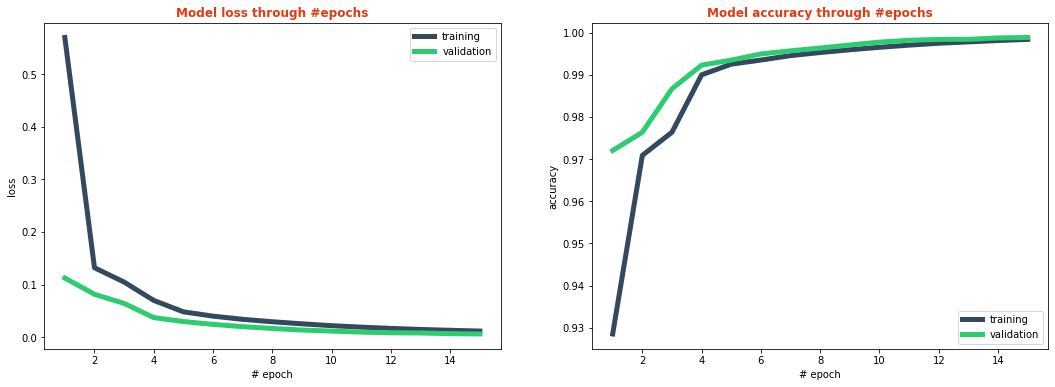

In [19]:
kfold = KFold(n_splits=NUM_FOLDS, shuffle=True)

fold_no = 1
ar_pr_tr = []

for train_index, test_index in kfold.split(input_ids):
    
    history = model.fit([input_ids[train_index], 
                         token_ids[train_index], 
                         attention_masks[train_index]],
                        label_ids[train_index],
                        validation_split = VAL_SPLIT,
                        batch_size       = int(_BACH_SIZE * factor_b),
                        epochs           = _EPOCHS,
                        verbose          = 1)
    
    scores = model.evaluate([input_ids[test_index], token_ids[test_index], attention_masks[test_index]], label_ids[test_index])
    
    print("\neval: ",
          f"{model.metrics_names[0]}: {scores[1] * 100}",
          f"{model.metrics_names[1]}: {scores[1] * 100}","\n")
    
    if fold_no == 1:
        print('>>>>>>', fold_no)
        plot_model_performance(
            train_loss     = history.history.get('loss', []),
            train_acc      = history.history.get('accuracy', []),
            train_val_loss = history.history.get('val_loss', []),
            train_val_acc  = history.history.get('val_accuracy', [])
        )
    
    prediction = model.predict([input_ids[test_index], token_ids[test_index], attention_masks[test_index]])
    
    pred_tags = np.argmax(prediction,-1)
    #print(pred_tags[0])
    
    y_pred = logits_to_tokens(pred_tags, le_dict)
    #print(y_pred[0])
    
    y_true = logits_to_tokens(label_ids[test_index], le_dict)
    #print(y_true[0])
    
    arr_save = save_base_dir + "/arr_lung.npy"

    ar_pr_tr.append((ill_tokens[test_index], [y_true, y_pred]))

    ary = np.array(ar_pr_tr)

    np.save(arr_save, ary)
    
    li1 = sum(y_true, [])
    li2 = sum(y_pred, [])
    
    results = pd.DataFrame(columns=['Expected', 'Predicted'])
    results['Expected']  = li1
    results['Predicted'] = li2
    
    print("precision: {:.1%}".format(precision_score(y_true, y_pred)))
    print("   recall: {:.1%}".format(recall_score(y_true,    y_pred)))
    print(" accuracy: {:.1%}".format(accuracy_score(y_true,  y_pred)))
    print(" F1-score: {:.1%}".format(f1_score(y_true,        y_pred)), "\n")
    
    info = []

    info.append("precision: {:.1%}".format(precision_score(y_true, y_pred)))
    info.append("   recall: {:.1%}".format(recall_score(y_true,    y_pred)))
    info.append(" accuracy: {:.1%}".format(accuracy_score(y_true,  y_pred)))
    info.append(" F1-score: {:.1%}".format(f1_score(y_true,        y_pred)))

    prime_data_fold.append(info)
    
    report = eskclarep(results['Expected'], results['Predicted'])
    
    total_data_fold.append(report_to_df2(report, '-fol' + str(fold_no)))
    
    print(report_to_df2(report, '-fol' + str(fold_no)), "\n")
    
    # Increase fold number
    fold_no += 1

### se almacena las estadisticas

In [20]:
output1 = open('./prime_data_fold-10k-model-08.pkl', 'wb')
pickle.dump(prime_data_fold, output1)
output1.close()

output2 = open('./total_data_fold-10k-model-08.pkl', 'wb')
pickle.dump(total_data_fold, output2)
output2.close()

## se almacena el modelo

In [21]:
save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')

#tf.saved_model.save(model, export_dir=save_dir)
#tf.saved_model.save(model, export_dir=save_locally)

model.save('./model', options=save_locally)

2022-02-03 15:34:59.117409: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
